## 1. Introduction

Notebook for generating lyrics using LSTM network. The dataset contains all the songs recorded by Bob Dylan. Stages:
1. EDA
    - Summary statistics on dataset: distribution of no. of characters, words, sentences in collection
    - Histograms & wordclouds
2. Preprocessing
    - Create corpus of all words from lyrics
    - Cleaning: remove special characters, convert to lowercase
    - Create mapping of unique chars to indices
    - Create features and targets (categorical)
3. Model
    - Train LSTM model, one character at a time
    - Visualize learning and loss
4. Generation
    - Generate lyrics from seed phrase, one character at a time, using model predictions

In [9]:
# Imports
# Core
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import string, os, sys, warnings, random, io
warnings.filterwarnings("ignore")

# NLP
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense, Dropout
import nltk
import re
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from PIL import Image

In [ ]:
# TPU config (for LSTM)
tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect()
tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)

<a id="2"></a>
## 2. EDA

In [5]:
# Load song lyrics dataset
df_songs = pd.read_csv("../input/bob-dylan-songs/clear.csv")
df_songs.head()

,release_year,album,title,lyrics
0,1961,"The Bootleg Series, Vol 1-3: Rare & Unreleased...",Hard Times In New York Town,"Come you ladies and you gentlemen, a-listen to..."
1,1961,"The Bootleg Series, Vol 1-3: Rare & Unreleased...",Man on the street,"’ll sing you a song, ain’t very long\n\n’Bout ..."
2,1962,"The Bootleg Series, Vol 1-3: Rare & Unreleased...",Talkin’ Bear Mountain Picnic Massacre Blues,I saw it advertised one day\n\nBear Mountain p...
3,1962,"The Bootleg Series, Vol 1-3: Rare & Unreleased...",Let Me Die in My Footsteps,I will not go down under the ground\n\n’Cause ...
4,1962,"The Bootleg Series, Vol 1-3: Rare & Unreleased...","Rambling, Gambling Willie",Come around you rovin’ gamblers and a story I ...


In [6]:
df_songs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 345 entries, 0 to 344
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   release_year  345 non-null    int64 
 1   album         345 non-null    object
 2   title         345 non-null    object
 3   lyrics        345 non-null    object
dtypes: int64(1), object(3)
memory usage: 10.9+ KB


### 2.1 Summary stats

In [7]:
# Get numbers of characters,words and sentences in each song
df_songs["n_chars"] = df_songs["lyrics"].apply(len)
df_songs["n_words"]=df_songs.apply(lambda row: nltk.word_tokenize(row["lyrics"]), axis=1).apply(len)
df_songs["n_lines"] = df_songs["lyrics"].str.split('\n').apply(len)
df_songs.describe()

,release_year,n_chars,n_words,n_lines
count,345.000000,345.000000,345.000000,345.000000
mean,1979.486957,1593.336232,351.159420,92.321739
std,15.441393,992.046017,214.159907,53.067621
min,1961.000000,75.000000,11.000000,3.000000
25%,1966.000000,1003.000000,220.000000,57.000000
50%,1975.000000,1330.000000,299.000000,81.000000
75%,1988.000000,1867.000000,416.000000,108.000000
max,2020.000000,8938.000000,1884.000000,448.000000


<AxesSubplot:xlabel='n_lines', ylabel='Count'>

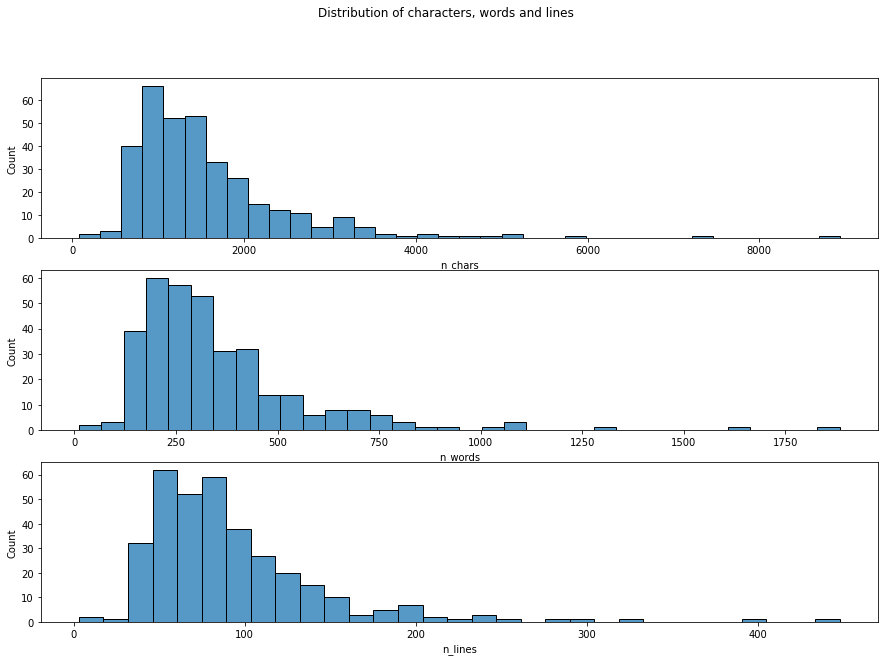

In [8]:
# Plot distribution of chars, words, sentences in lyrics
fig, axs = plt.subplots(3, 1, figsize=(15, 10))
fig.suptitle('Distribution of characters, words and lines')
sns.histplot(data=df_songs, x='n_chars', ax=axs[0])
sns.histplot(data=df_songs, x='n_words', ax=axs[1])
sns.histplot(data=df_songs, x='n_lines', ax=axs[2])

### 2.2 Wordcloud

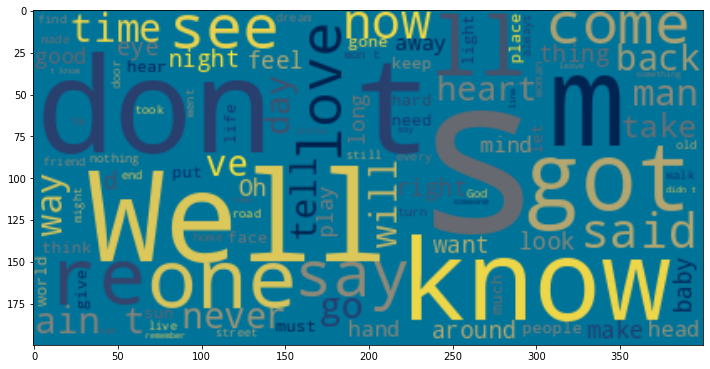

In [28]:
# Generate a wordcloud
stopwords = set(STOPWORDS)
wc = WordCloud(stopwords=stopwords, background_color="#007399",colormap="cividis", max_words=100)
wc.generate(" ".join(df_songs.lyrics))
plt.figure(figsize=(12,12))
plt.imshow(wc, interpolation="bilinear")
plt.show()

In [33]:
# Sample lyrics
song_idx = 100
print(df_songs.loc[song_idx, :])
df_songs.loc[song_idx, 'lyrics'].split('\n')[:30]

release_year                                                 1967
album                                         John Wesley Harding
title                  The Ballad of Frankie Lee and Judas Priest
lyrics          Well, Frankie Lee and Judas Priest\n \n They w...
n_chars                                                      3160
n_words                                                       682
n_lines                                                       195
Name: 100, dtype: object


['Well, Frankie Lee and Judas Priest',
 ' ',
 ' They were the best of friends',
 ' ',
 ' So when Frankie Lee needed money one day',
 ' ',
 ' Judas quickly pulled out a roll of tens',
 ' ',
 ' And placed them on a footstool',
 ' ',
 ' Just above the plotted plain',
 ' ',
 ' Sayin’, “Take your pick, Frankie Boy',
 ' ',
 ' My loss will be your gain”',
 ' ',
 ' ',
 ' ',
 ' Well, Frankie Lee, he sat right down',
 ' ',
 ' And put his fingers to his chin',
 ' ',
 ' But with the cold eyes of Judas on him',
 ' ',
 ' His head began to spin',
 ' ',
 ' “Would ya please not stare at me like that,” he said',
 ' ',
 ' “It’s just my foolish pride',
 ' ']

## 3. Preprocessing

In [ ]:
df_songs.shape

### 3.1 Create corpus

In [38]:
# Create corpus from lyrics
corpus = ''
for text in df_songs.lyrics:
    corpus += text
    
corpus = corpus.lower()
print("Number of unique characters:", len(set(corpus)))

Number of unique characters: 65


###  3.2 Cleaning

In [39]:
print(sorted(set(corpus)))

['\n', '\x0b', ' ', '!', '"', "'", '(', ')', ',', '-', '.', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';', '?', '`', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '¥', '©', 'é', 'ñ', 'ó', 'ü', '–', '—', '‘', '’', '“', '”', '…', '\u2028']


In [40]:
special_chars = ['\x0b', '"', '(', ')', '`', '¥', '©', 'é', 'ñ', 'ó', 'ü', '—', '“', '”', '…', '\u2028']
for symbol in special_chars:
    corpus = corpus.replace(symbol,"")
# corpus = re.sub("[^A-Za-z0-9'.,?!\n\w]","",corpus)

In [41]:
print(sorted(set(corpus)))

['\n', ' ', '!', "'", ',', '-', '.', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';', '?', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '–', '‘', '’']


In [42]:
# Sample section
corpus[:1000]

'come you ladies and you gentlemen, a-listen to my song\n\nsing it to you right, but you might think it’s wrong\n\njust a little glimpse of a story i’ll tell\n\n’bout an east coast city that you all know well\n\nit’s hard times in the city\n\nlivin’ down in new york town\n\n\n\nold new york city is a friendly old town\n\nfrom washington heights to harlem on down\n\nthere’s a-mighty many people all millin’ all around\n\nthey’ll kick you when you’re up and knock you when you’re down\n\nit’s hard times in the city\n\nlivin’ down in new york town\n\n\n\nit’s a mighty long ways from the golden gate\n\nto rockefeller plaza ’n’ the empire state.\n\nmister rockefeller sets up as high as a bird\n\nold mister empire never says a word\n\nit’s hard times from the country\n\nlivin’ down in new york town\n\n\n\nwell, it’s up in the mornin’ tryin’ to find a job of work\n\nstand in one place till your feet begin to hurt\n\nif you got a lot o’ money you can make yourself merry\n\nif you only got a nick

<a id="3.3"></a>
### 3.3 Create inputs from mapping

In [44]:
# Map characters in corpus to indices
symb = sorted(list(set(corpus)))

len_corpus = len(corpus) 
len_symb = len(symb)

mapping = dict((c, i) for i, c in enumerate(symb))
reverse_mapping = dict((i, c) for i, c in enumerate(symb))

print("Total number of characters:", len_corpus)
print("Number of unique characters:", len_symb)

Total number of characters: 548593
Number of unique characters: 49


In [61]:
#Splitting the corpus in equal length of strings and output target
length = 50
features = []
targets = []
for i in range(0, len_corpus - length, 1):
    feature = corpus[i:i + length]
    target = corpus[i + length]
    features.append([mapping[j] for j in feature])
    targets.append(mapping[target])
    
# len_datapoints = len(targets)
# print("Total number of sequences in the Corpus:", len_datapoints)

In [63]:
# reshape X and normalize
X = (np.reshape(features, (len(targets), length, 1)))/ float(len_symb)

# one hot encode the output variable
y = to_categorical(targets)

## 4. Model

### 4.1 Training

In [64]:
#Initialising the Model
with tpu_strategy.scope():
    model = Sequential()
    model.add(LSTM(256, input_shape=(X.shape[1], X.shape[2])))
    model.add(Dense(y.shape[1], activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam')
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 256)               264192    
_________________________________________________________________
dense_1 (Dense)              (None, 49)                12593     
Total params: 276,785
Trainable params: 276,785
Non-trainable params: 0
_________________________________________________________________


In [65]:
%%time
#Training the Model
history = model.fit(X, y, batch_size=256*tpu_strategy.num_replicas_in_sync, epochs=50)

Epoch 1/50
268/268 [==============================] - 9s 17ms/step - loss: 3.0756
Epoch 2/50
268/268 [==============================] - 4s 14ms/step - loss: 2.8562
Epoch 3/50
268/268 [==============================] - 4s 14ms/step - loss: 2.7715
Epoch 4/50
268/268 [==============================] - 4s 14ms/step - loss: 2.7011
Epoch 5/50
268/268 [==============================] - 4s 14ms/step - loss: 2.6631
Epoch 6/50
268/268 [==============================] - 4s 14ms/step - loss: 2.6197
Epoch 7/50
268/268 [==============================] - 4s 14ms/step - loss: 2.5924
Epoch 8/50
268/268 [==============================] - 4s 14ms/step - loss: 2.5620
Epoch 9/50
268/268 [==============================] - 4s 15ms/step - loss: 2.5384
Epoch 10/50
268/268 [==============================] - 4s 14ms/step - loss: 2.5131
Epoch 11/50
268/268 [==============================] - 4s 14ms/step - loss: 2.4917
Epoch 12/50
268/268 [==============================] - 4s 14ms/step - loss: 2.4776
Epoch 13/50
2

model.save("generator_v2.h5")

### 4.2 Evaluation

[Text(0.5, 0, 'Epochs')]

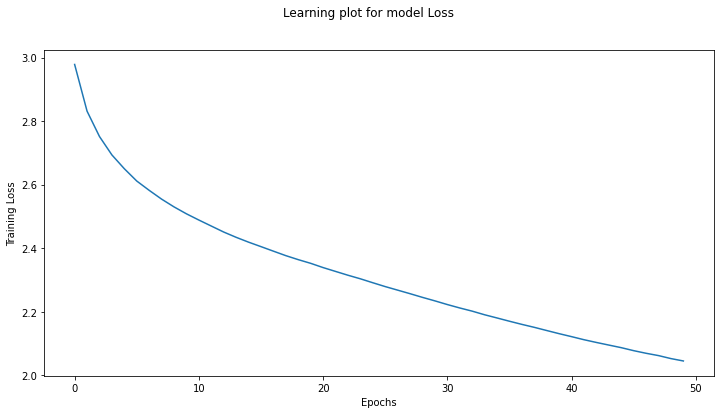

In [66]:
# Evaluation
history_df = pd.DataFrame(history.history)
#Plotting the learning curve

fig = plt.figure(figsize=(12,6))
fig.suptitle("Learning plot for model Loss")
pl = sns.lineplot(data=history_df["loss"])
pl.set(ylabel ="Training Loss")
pl.set(xlabel ="Epochs")

## 5. Generation

In [67]:
# The function to generate text from model
def generate(seed,char_count, temperature=1.0):
    generated= ""
    seed = seed 
    seed_idx=[mapping[char] for char in seed]
    generated += seed 
    # Generating new text of given length
    for i in range(char_count):
        seed_idx=[mapping[char] for char in seed]
        x_pred = np.reshape(seed_idx, (1, len(seed_idx), 1))/len_symb
        prediction = model.predict(x_pred, verbose=0)[0]  
        # Getting the index of the next most probable index
        prediction = np.asarray(prediction).astype('float64')
        prediction = np.log(prediction) / temperature
#         exp_preds = np.exp(prediction)
#         prediction = exp_preds / np.sum(exp_preds)
#         probas = np.random.multinomial(1, prediction, 1)
        index = np.argmax(prediction)
        next_char = reverse_mapping[index]  
        # Generating new text
        generated += next_char
        seed = seed[1:] + next_char
       
    return generated

In [68]:
song = generate("the answer my friend, is blowi", 50, 2.0)
song.split('\n')

['the answer my friend, is blowi yhu want',
 '',
 'they ladd iy your doen',
 ' io toen yhu  bn']

In [69]:
song = generate("the times they ar", 200)
song.split('\n')

['the times they aryy arnn rr yrur drud ytrrrdddyyrr krrd yourrdddy',
 'krre drnn irrd drye tr yeurr,’hr rrre yrur',
 '',
 'dnye yerr drre tr yeurr,’hr rrre yrur',
 '',
 'dnye yerr drre tr yeurr,’hr rrre yrur',
 '',
 'dnye yerr drre tr yeurr,’hr r']